In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device: ", device)

Device:  cuda


# 1. Dataset Definition

In [5]:
class FluidDataset(Dataset):
    def __init__(self, input_dir, target_dir):
        self.ux_files = sorted([f for f in os.listdir(input_dir) if f.startswith("ux")])
        self.uy_files = sorted([f for f in os.listdir(input_dir) if f.startswith("uy")])
        self.target_files = sorted(os.listdir(target_dir))
        
        # Check if file counts match
        if not (len(self.ux_files) == len(self.uy_files) == len(self.target_files)):
            raise ValueError("Input files and target files do not match in quantity.")
        
        self.input_dir = input_dir
        self.target_dir = target_dir

    def __len__(self):
        return len(self.target_files)

    def __getitem__(self, idx):
        ux = np.load(os.path.join(self.input_dir, self.ux_files[idx])).squeeze(0)
        uy = np.load(os.path.join(self.input_dir, self.uy_files[idx])).squeeze(0)
        input_data = np.concatenate((ux, uy), axis=0)

        target = np.load(os.path.join(self.target_dir, self.target_files[idx])).squeeze(0)

        return torch.tensor(input_data, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


# 2. Model Definition

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout_rate=0.3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return self.relu(out)

# 主模型定义
class ModelA_ResNet(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ModelA_ResNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ResidualBlock(64, 64, dropout_rate=dropout_rate),
            ResidualBlock(64, 128, stride=2, dropout_rate=dropout_rate),
            ResidualBlock(128, 256, stride=2, dropout_rate=dropout_rate),
            ResidualBlock(256, 512, stride=2, dropout_rate=dropout_rate),
        )
        
        # 调整解码器中的上采样次数以匹配 512x512 输出
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ResidualBlock(256, 256, dropout_rate=dropout_rate),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ResidualBlock(128, 128, dropout_rate=dropout_rate),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ResidualBlock(64, 64, dropout_rate=dropout_rate),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            ResidualBlock(32, 32, dropout_rate=dropout_rate),

            nn.ConvTranspose2d(32, 4, kernel_size=3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x  # 直接输出 512x512 的结果


# 3. Training and Testing Functions

In [7]:
# def calculate_accuracy(output, target, threshold=0.1):
#     return (torch.abs(output - target) < threshold).float().mean().item()


def calculate_accuracy(output, target, threshold=0.1):
    # 分别计算每个通道的准确率
    accuracy_part1 = (torch.abs(output[:, 0, :, :] - target[:, 0, :, :]) < threshold).float().mean().item()
    accuracy_part2 = (torch.abs(output[:, 1, :, :] - target[:, 1, :, :]) < threshold).float().mean().item()
    accuracy_part3 = (torch.abs(output[:, 2, :, :] - target[:, 2, :, :]) < threshold).float().mean().item()
    accuracy_part4 = (torch.abs(output[:, 3, :, :] - target[:, 3, :, :]) < threshold).float().mean().item()
    
    # 计算总准确率为每个通道准确率的平均
    overall_accuracy = (accuracy_part1 + accuracy_part2 + accuracy_part3 + accuracy_part4) / 4
    return overall_accuracy


In [8]:
def train_model(model, dataloader, criterion, num_epochs=100, threshold=0.1, save_epochs=[1, 50, 100]):
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
    writer = SummaryWriter(log_dir='training_logs')
    model.train()
    
    epoch_losses, epoch_accuracies = [], []
    for epoch in range(num_epochs):
        running_loss, running_accuracy = 0.0, 0.0
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)

            # print("outputs shape:", outputs.shape)
            # print("targets shape:", targets.shape)

            loss_part1 = criterion(outputs[:, 0, :, :], targets[:, 0, :, :])
            loss_part2 = criterion(outputs[:, 1, :, :], targets[:, 1, :, :])
            loss_part3 = criterion(outputs[:, 2, :, :], targets[:, 2, :, :])
            loss_part4 = criterion(outputs[:, 3, :, :], targets[:, 3, :, :])

            # plt.subplot(1, 2, 1)
            # plt.imshow(outputs[0, 2, :, :].detach().cpu().numpy())
            # plt.subplot(1, 2, 2)
            # plt.imshow(targets[0, 2, :, :].detach().cpu().numpy())
            # plt.show()

            loss = 0.25 * loss_part1 + 0.25 * loss_part2 + 0.25 * loss_part3 + 0.25 * loss_part4
            
            # loss = criterion(outputs, targets)
            accuracy = calculate_accuracy(outputs, targets, threshold=threshold)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_accuracy += accuracy

            if i % 10 == 0:
                writer.add_scalar('Training Loss', loss.item(), epoch * len(dataloader) + i)
                writer.add_scalar('Training Accuracy', accuracy, epoch * len(dataloader) + i)
        
        epoch_losses.append(running_loss / len(dataloader))
        epoch_accuracies.append(running_accuracy / len(dataloader))
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses[-1]:.4f}, Accuracy: {epoch_accuracies[-1]:.4f}")
        
    writer.close()
    np.save('epoch_losses.npy', np.array(epoch_losses))
    np.save('epoch_accuracies.npy', np.array(epoch_accuracies))


In [9]:
def test_model(model, dataloader, criterion, threshold=0.1):
    model.eval()
    test_loss, test_accuracy = 0.0, 0.0
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)

            loss_part1 = criterion(outputs[:, 0, :, :], targets[:, 0, :, :])
            loss_part2 = criterion(outputs[:, 1, :, :], targets[:, 1, :, :])
            loss_part3 = criterion(outputs[:, 2, :, :], targets[:, 2, :, :])
            loss_part4 = criterion(outputs[:, 3, :, :], targets[:, 3, :, :])

            loss = 0.25 * loss_part1 + 0.25 * loss_part2 + 0.25 * loss_part3 + 0.25 * loss_part4
            # loss = criterion(outputs, targets)
            accuracy = calculate_accuracy(outputs, targets, threshold=threshold)

            test_loss += loss.item()
            test_accuracy += accuracy
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_test_loss = test_loss / len(dataloader)
    avg_test_accuracy = test_accuracy / len(dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_accuracy:.4f}")

    # 保存预测和目标数据
    np.save('predictions.npy', np.concatenate(all_predictions, axis=0))
    np.save('targets.npy', np.concatenate(all_targets, axis=0))

    # 返回平均测试损失和准确率
    return avg_test_loss, avg_test_accuracy


In [10]:
def evaluate_model(model, dataloader, criterion, threshold=0.1, dataset_name="Dataset"):
    model.eval()
    total_loss, total_accuracy = 0.0, 0.0
    all_predictions, all_targets = [], []

    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs, targets = imgs.to(device), targets.to(device)
            outputs = model(imgs)

            loss_part1 = criterion(outputs[:, 0, :, :], targets[:, 0, :, :])
            loss_part2 = criterion(outputs[:, 1, :, :], targets[:, 1, :, :])
            loss_part3 = criterion(outputs[:, 2, :, :], targets[:, 2, :, :])
            loss_part4 = criterion(outputs[:, 3, :, :], targets[:, 3, :, :])

            loss = 0.25 * loss_part1 + 0.25 * loss_part2 + 0.25 * loss_part3 + 0.25 * loss_part4

            
            # loss = criterion(outputs, targets)
            accuracy = calculate_accuracy(outputs, targets, threshold=threshold)

            total_loss += loss.item()
            total_accuracy += accuracy
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    avg_accuracy = total_accuracy / len(dataloader)
    print(f"{dataset_name} Loss: {avg_loss:.4f}, {dataset_name} Accuracy: {avg_accuracy:.4f}")

    # 保存预测和目标数据
    np.save(f'{dataset_name.lower()}_predictions.npy', np.concatenate(all_predictions, axis=0))
    np.save(f'{dataset_name.lower()}_targets.npy', np.concatenate(all_targets, axis=0))

    return avg_loss, avg_accuracy


# 4. Velocity Calculation Function

In [11]:
def calculate_velocity(psi_real, psi_imag):
    da_dx, da_dy = np.gradient(psi_real[0], axis=(1, 0))
    db_dx, db_dy = np.gradient(psi_imag[0], axis=(1, 0))
    dc_dx, dc_dy = np.gradient(psi_real[1], axis=(1, 0))
    dd_dx, dd_dy = np.gradient(psi_imag[1], axis=(1, 0))

    u_x = psi_real[0] * db_dx - psi_imag[0] * da_dx + psi_real[1] * dd_dx - psi_imag[1] * dc_dx
    u_y = psi_real[0] * db_dy - psi_imag[0] * da_dy + psi_real[1] * dd_dy - psi_imag[1] * dc_dy

    return u_x, u_y

# 5. Main Training and Testing Workflow

In [12]:
if __name__ == "__main__":


    # Directories
    train_input_dir = 'D:/zjPhD/Programzj/psitouTest/GLT_Noise_Net/data/modelA/train/input'
    train_target_dir = 'D:/zjPhD/Programzj/psitouTest/GLT_Noise_Net/data/modelA/train/target'
    test_input_dir = 'D:/zjPhD/Programzj/psitouTest/GLT_Noise_Net/data/modelA/test/input'
    test_target_dir = 'D:/zjPhD/Programzj/psitouTest/GLT_Noise_Net/data/modelA/test/target'

    # Prepare datasets and dataloaders
    train_dataset = FluidDataset(train_input_dir, train_target_dir)
    train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

    test_dataset = FluidDataset(test_input_dir, test_target_dir)
    test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

    # Initialize model, loss, and optimizer
    model = ModelA_ResNet().to(device)
    criterion = nn.MSELoss()

    # Train the model
    train_model(model, train_dataloader, criterion, num_epochs=1000, threshold=0.1)

    # Save trained model
    torch.save(model.state_dict(), 'modelA_trained.pth')


    model.load_state_dict(torch.load('modelA_trained.pth'))
    train_loss, train_accuracy = evaluate_model(model, train_dataloader, criterion, threshold=0.1, dataset_name="Train")

    # Evaluate on test set
    test_loss, test_accuracy = evaluate_model(model, test_dataloader, criterion, threshold=0.1, dataset_name="Test")

    # Visualization of loss and accuracy for both train and test
    epoch_losses = np.load('epoch_losses.npy')
    epoch_accuracies = np.load('epoch_accuracies.npy')
    train_predictions = np.load('train_predictions.npy')
    train_targets = np.load('train_targets.npy')
    test_predictions = np.load('test_predictions.npy')
    test_targets = np.load('test_targets.npy')

    # Plotting training loss and accuracy
    fig, ax1 = plt.subplots()
    ax1.plot(epoch_losses, 'b-', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(epoch_accuracies, 'r-', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Training Loss and Accuracy')
    fig.tight_layout()
    plt.show()

    # Display sample predictions vs targets for training set
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    titles = ['psi1_real', 'psi1_imag', 'psi2_real', 'psi2_imag']
    fig.suptitle("Training Set Predictions vs Targets")

    for i in range(4):
        # Training Target data
        axes[0, i].imshow(train_targets[0, i], cmap='RdBu_r')
        axes[0, i].set_title(f"Target {titles[i]}")
        
        # Training Prediction data
        axes[1, i].imshow(train_predictions[0, i], cmap='RdBu_r')
        axes[1, i].set_title(f"Prediction {titles[i]}")

    plt.show()

    # Display sample predictions vs targets for test set
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle("Test Set Predictions vs Targets")

    for i in range(4):
        # Test Target data
        axes[0, i].imshow(test_targets[0, i], cmap='RdBu_r')
        axes[0, i].set_title(f"Target {titles[i]}")
        
        # Test Prediction data
        axes[1, i].imshow(test_predictions[0, i], cmap='RdBu_r')
        axes[1, i].set_title(f"Prediction {titles[i]}")

    plt.show()

KeyboardInterrupt: 

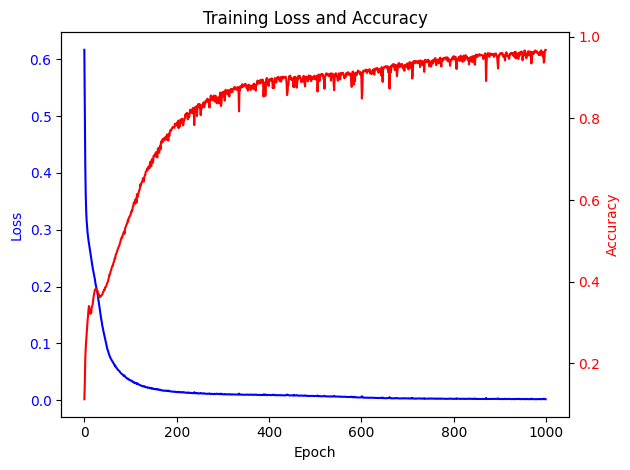

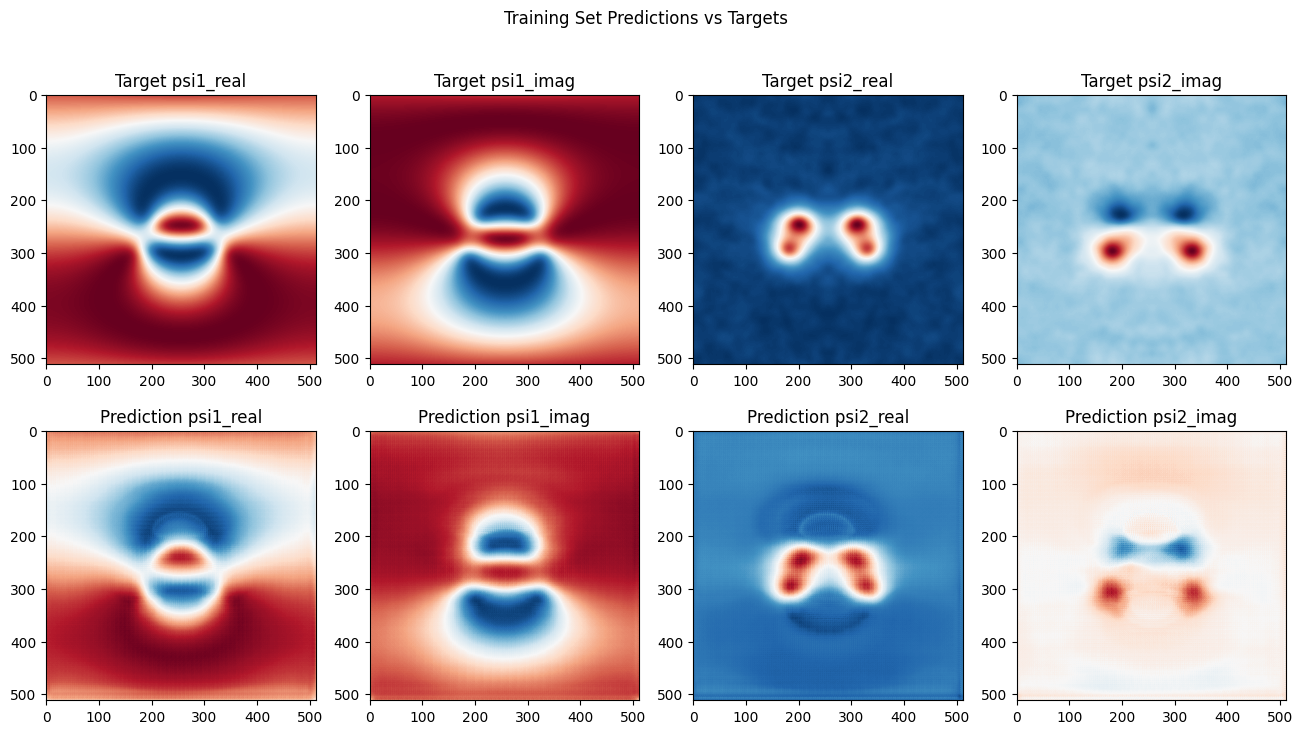

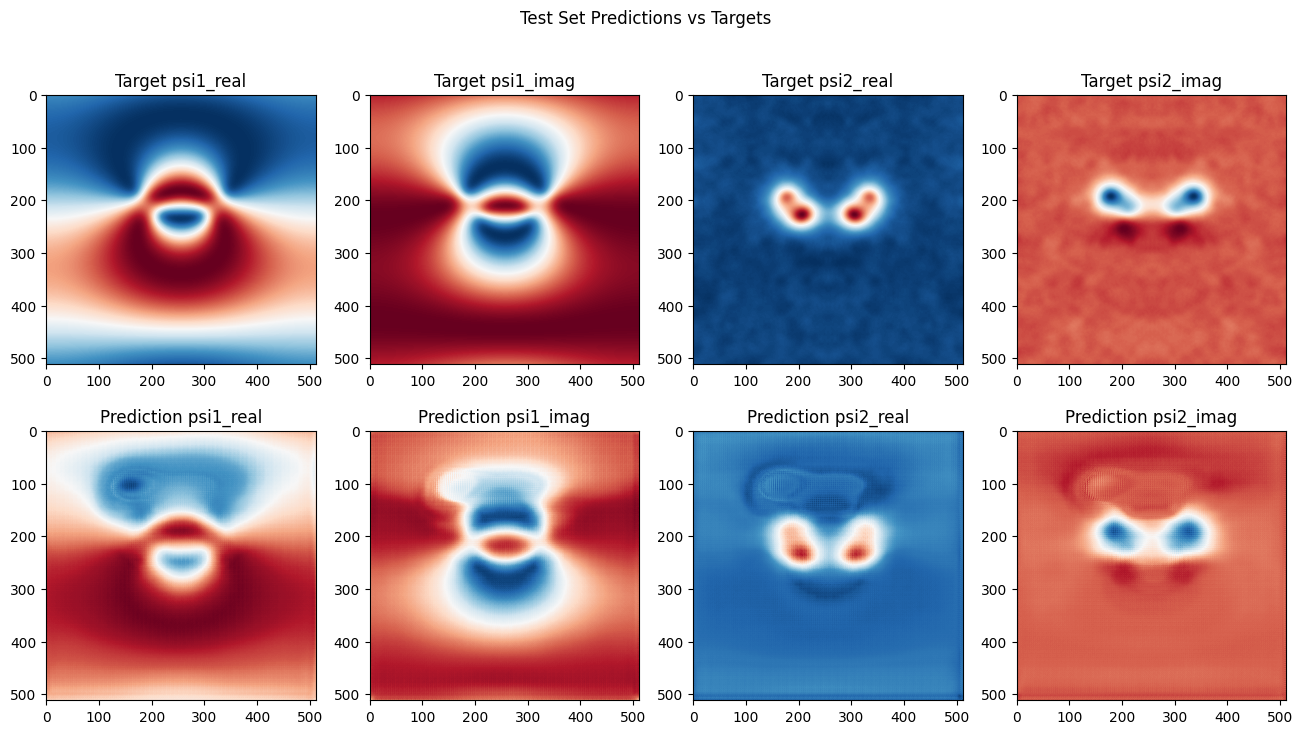

In [ ]:
if __name__ == "__main__":    
# Plotting training loss and accuracy
    fig, ax1 = plt.subplots()
    ax1.plot(epoch_losses, 'b-', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(epoch_accuracies, 'r-', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Training Loss and Accuracy')
    fig.tight_layout()

    plt.savefig('watiao\\bc_1\\training_loss_accuracy.png')
    plt.show()

    # Display sample predictions vs targets for training set
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    titles = ['psi1_real', 'psi1_imag', 'psi2_real', 'psi2_imag']
    fig.suptitle("Training Set Predictions vs Targets")

    for i in range(4):
        # Training Target data
        axes[0, i].imshow(train_targets[0, i], cmap='RdBu_r')
        axes[0, i].set_title(f"Target {titles[i]}")
        
        # Training Prediction data
        axes[1, i].imshow(train_predictions[0, i], cmap='RdBu_r')
        axes[1, i].set_title(f"Prediction {titles[i]}")
    
    plt.savefig('watiao\\bc_1\\training_predictions_targets.png')

    plt.show()

    # Display sample predictions vs targets for test set
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle("Test Set Predictions vs Targets")

    for i in range(4):
        # Test Target data
        axes[0, i].imshow(test_targets[0, i], cmap='RdBu_r')
        axes[0, i].set_title(f"Target {titles[i]}")
        
        # Test Prediction data
        axes[1, i].imshow(test_predictions[0, i], cmap='RdBu_r')
        axes[1, i].set_title(f"Prediction {titles[i]}")
    plt.savefig('watiao\\bc_1\\test_predictions_targets.png')

    plt.show()

# 尝试使用VGG

In [13]:
import torchvision
import torch
from torch import nn
import torch.nn as nn
import torchvision.models as models

In [14]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.classifier = nn.Identity()
vgg16.features[0] = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1)

model = nn.Sequential(
    vgg16.features,  # VGG-16 的卷积特征部分
    nn.Conv2d(512, 4, kernel_size=1),  # 将通道数从 512 减少到 4
    nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)  # 上采样到 512x512
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Epoch [1/2000], Loss: 0.2348, Accuracy: 0.4594
Epoch [2/2000], Loss: 0.2066, Accuracy: 0.4905
Epoch [3/2000], Loss: 0.1986, Accuracy: 0.4958
Epoch [4/2000], Loss: 0.1898, Accuracy: 0.4969
Epoch [5/2000], Loss: 0.1778, Accuracy: 0.4980
Epoch [6/2000], Loss: 0.1656, Accuracy: 0.4969
Epoch [7/2000], Loss: 0.1610, Accuracy: 0.4963
Epoch [8/2000], Loss: 0.1456, Accuracy: 0.5058
Epoch [9/2000], Loss: 0.1296, Accuracy: 0.5146
Epoch [10/2000], Loss: 0.1214, Accuracy: 0.5201
Epoch [11/2000], Loss: 0.1142, Accuracy: 0.5300
Epoch [12/2000], Loss: 0.1032, Accuracy: 0.5318
Epoch [13/2000], Loss: 0.1036, Accuracy: 0.5346
Epoch [14/2000], Loss: 0.0901, Accuracy: 0.5548
Epoch [15/2000], Loss: 0.0855, Accuracy: 0.5535
Epoch [16/2000], Loss: 0.0841, Accuracy: 0.5548
Epoch [17/2000], Loss: 0.0796, Accuracy: 0.5673
Epoch [18/2000], Loss: 0.0767, Accuracy: 0.5614
Epoch [19/2000], Loss: 0.0714, Accuracy: 0.5816
Epoch [20/2000], Loss: 0.0702, Accuracy: 0.5834
Epoch [21/2000], Loss: 0.0668, Accuracy: 0.5926
E

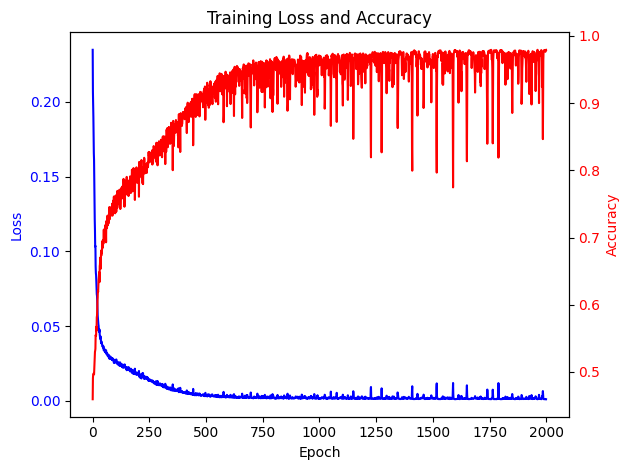

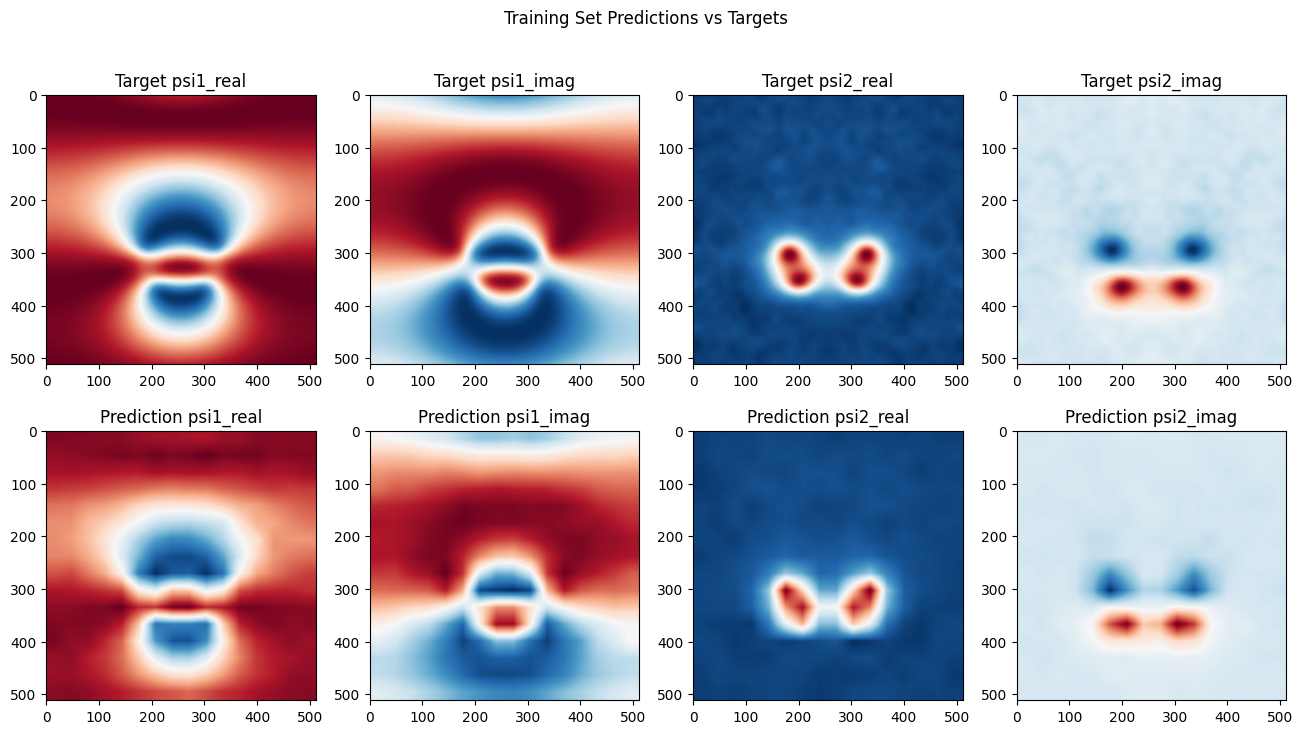

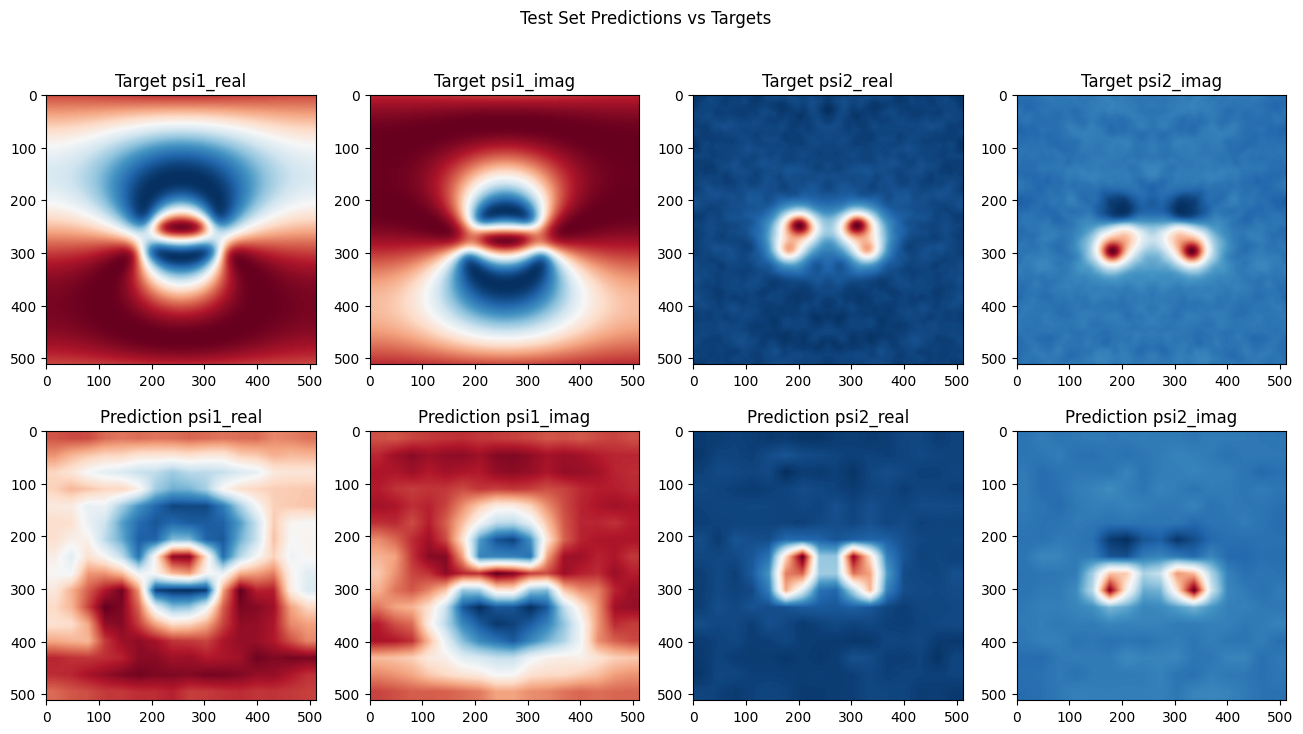

In [16]:
if __name__ == "__main__":


    # Directories
    train_input_dir = 'D:/zjPhD/Programzj/psitouTest/GLT_Noise_Net/data/modelA/train/input'
    train_target_dir = 'D:/zjPhD/Programzj/psitouTest/GLT_Noise_Net/data/modelA/train/target'
    test_input_dir = 'D:/zjPhD/Programzj/psitouTest/GLT_Noise_Net/data/modelA/test/input'
    test_target_dir = 'D:/zjPhD/Programzj/psitouTest/GLT_Noise_Net/data/modelA/test/target'

    # Prepare datasets and dataloaders
    train_dataset = FluidDataset(train_input_dir, train_target_dir)
    train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

    test_dataset = FluidDataset(test_input_dir, test_target_dir)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    # Initialize model, loss, and optimizer
    model = model.to(device)
    criterion = nn.MSELoss()

    # Train the model
    train_model(model, train_dataloader, criterion, num_epochs=2000, threshold=0.1)

    # Save trained model
    torch.save(model.state_dict(), 'modelA_trained.pth')


    model.load_state_dict(torch.load('modelA_trained.pth'))
    train_loss, train_accuracy = evaluate_model(model, train_dataloader, criterion, threshold=0.1, dataset_name="Train")

    # Evaluate on test set
    test_loss, test_accuracy = evaluate_model(model, test_dataloader, criterion, threshold=0.1, dataset_name="Test")

    # Visualization of loss and accuracy for both train and test
    epoch_losses = np.load('epoch_losses.npy')
    epoch_accuracies = np.load('epoch_accuracies.npy')
    train_predictions = np.load('train_predictions.npy')
    train_targets = np.load('train_targets.npy')
    test_predictions = np.load('test_predictions.npy')
    test_targets = np.load('test_targets.npy')

    # Plotting training loss and accuracy
    fig, ax1 = plt.subplots()
    ax1.plot(epoch_losses, 'b-', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(epoch_accuracies, 'r-', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Training Loss and Accuracy')
    fig.tight_layout()
    plt.show()

    # Display sample predictions vs targets for training set
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    titles = ['psi1_real', 'psi1_imag', 'psi2_real', 'psi2_imag']
    fig.suptitle("Training Set Predictions vs Targets")

    for i in range(4):
        # Training Target data
        axes[0, i].imshow(train_targets[0, i], cmap='RdBu_r')
        axes[0, i].set_title(f"Target {titles[i]}")
        
        # Training Prediction data
        axes[1, i].imshow(train_predictions[0, i], cmap='RdBu_r')
        axes[1, i].set_title(f"Prediction {titles[i]}")

    plt.show()

    # Display sample predictions vs targets for test set
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle("Test Set Predictions vs Targets")

    for i in range(4):
        # Test Target data
        axes[0, i].imshow(test_targets[0, i], cmap='RdBu_r')
        axes[0, i].set_title(f"Target {titles[i]}")
        
        # Test Prediction data
        axes[1, i].imshow(test_predictions[0, i], cmap='RdBu_r')
        axes[1, i].set_title(f"Prediction {titles[i]}")

    plt.show()

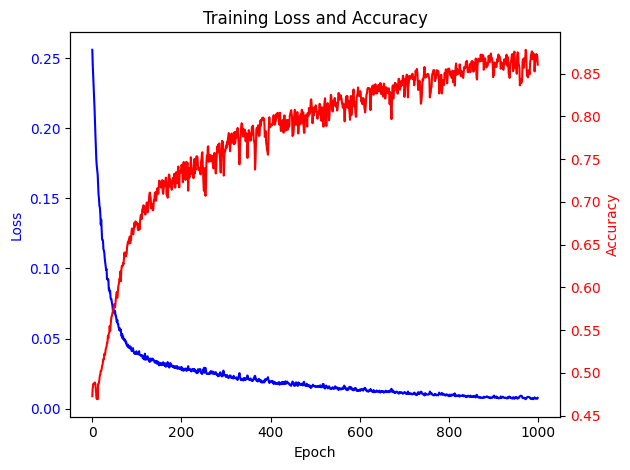

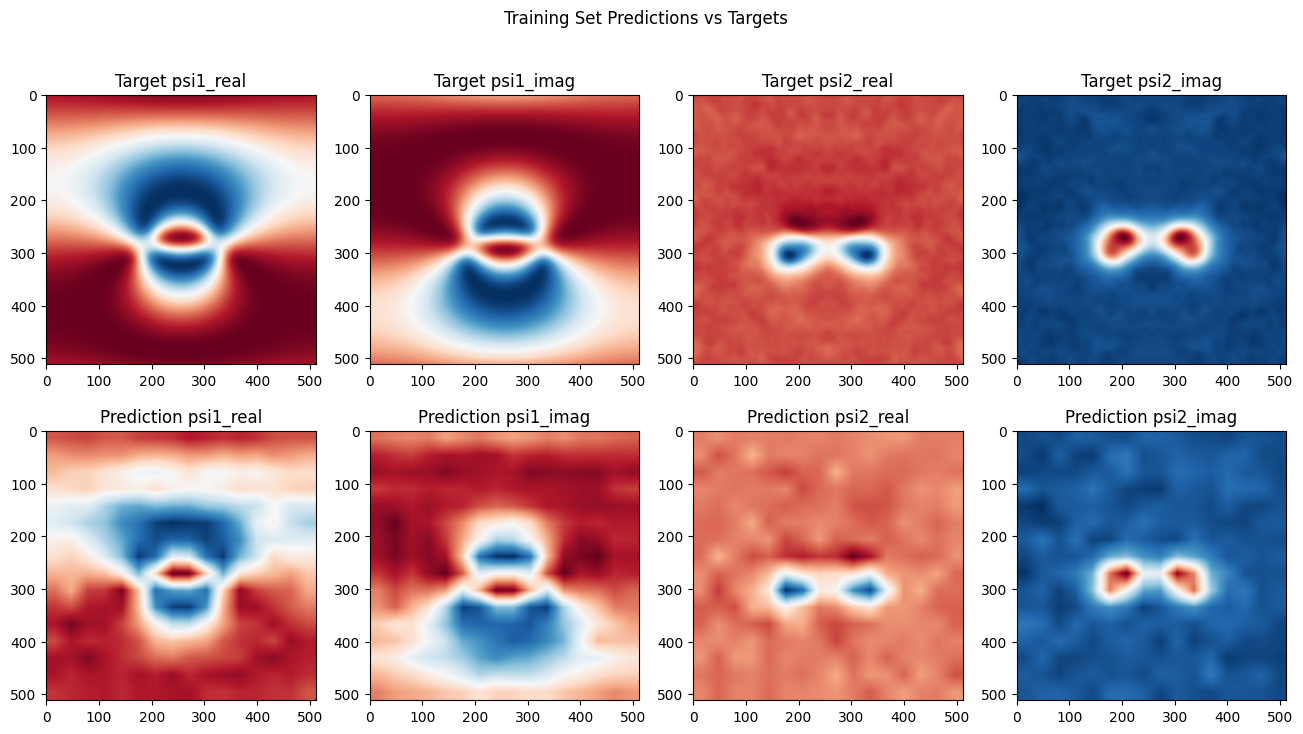

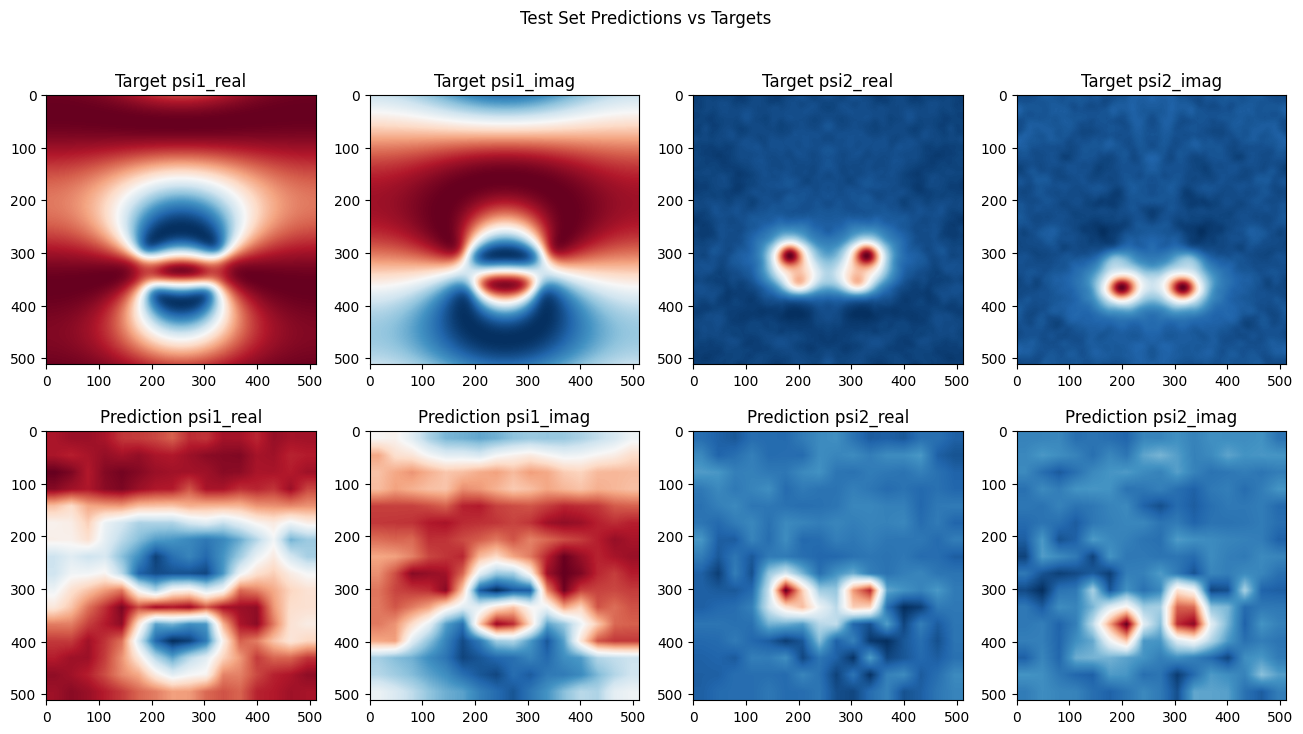

In [33]:
if __name__ == "__main__":    


    fig, ax1 = plt.subplots()
    ax1.plot(epoch_losses, 'b-', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(epoch_accuracies, 'r-', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    plt.title('Training Loss and Accuracy')
    fig.tight_layout()
    plt.savefig('watiao\\vgg\\bc_8\\training_loss_accuracy.png')
    plt.show()

    # Display sample predictions vs targets for training set
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    titles = ['psi1_real', 'psi1_imag', 'psi2_real', 'psi2_imag']
    fig.suptitle("Training Set Predictions vs Targets")

    for i in range(4):
        # Training Target data
        axes[0, i].imshow(train_targets[0, i], cmap='RdBu_r')
        axes[0, i].set_title(f"Target {titles[i]}")
        
        # Training Prediction data
        axes[1, i].imshow(train_predictions[0, i], cmap='RdBu_r')
        axes[1, i].set_title(f"Prediction {titles[i]}")

    plt.savefig('watiao\\vgg\\bc_8\\training_predictions_targets.png')

    plt.show()

    # Display sample predictions vs targets for test set
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle("Test Set Predictions vs Targets")

    for i in range(4):
        # Test Target data
        axes[0, i].imshow(test_targets[0, i], cmap='RdBu_r')
        axes[0, i].set_title(f"Target {titles[i]}")
        
        # Test Prediction data
        axes[1, i].imshow(test_predictions[0, i], cmap='RdBu_r')
        axes[1, i].set_title(f"Prediction {titles[i]}")
    plt.savefig('watiao\\vgg\\bc_8\\test_predictions_targets.png')

    plt.show()

In [14]:
train_targets.shape

(60, 4, 512, 512)

In [16]:
train_predictions.shape

(60, 4, 512, 512)

In [28]:
psi1_real = train_predictions[0,0,:,:]
psi1_imag = train_predictions[0,1,:,:]

psi2_real = train_predictions[0,2,:,:]
psi2_imag = train_predictions[0,3,:,:]




In [29]:
psi_real = np.array([psi1_real, psi2_real])
psi_imag = np.array([psi1_imag, psi2_imag])

In [30]:
ux, uy = calculate_velocity(psi_real, psi_imag)

In [31]:
ux.shape

(512, 512)

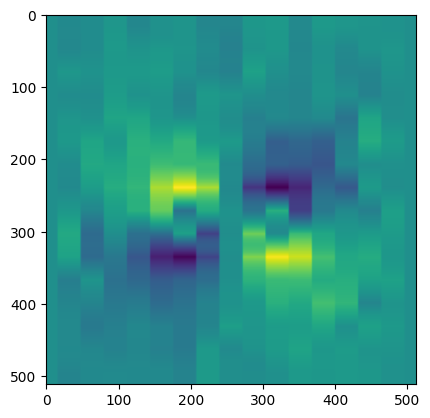

In [32]:
plt.imshow(ux)